In [210]:
import pandas as pd  #for data manipulation operations
import numpy as np   #for linear algebra

#Libraries for visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [211]:
#Loading the required data
df=pd.read_csv("C:/Users/lewis/Desktop/ML431/AAPL.csv")
df.set_index('Date',inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [212]:
print('Number of days present in the dataset: ',df.shape[0])
print('Number of fields present in the dataset: ',df.shape[1])

Number of days present in the dataset:  10409
Number of fields present in the dataset:  6


In [213]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10409.000000,10409.000000,10409.000000,10409.000000,10409.000000,1.040900e+04
mean,13.959910,14.111936,13.809163,13.966757,13.350337,3.321778e+08
std,30.169244,30.514878,29.835055,30.191696,29.911132,3.393344e+08
min,0.049665,0.049665,0.049107,0.049107,0.038384,0.000000e+00
25%,0.281964,0.287946,0.274554,0.281250,0.234799,1.247604e+08
50%,0.468750,0.477679,0.459821,0.468750,0.386853,2.199680e+08
75%,14.217857,14.364286,14.043571,14.206071,12.188149,4.126108e+08
max,182.630005,182.940002,179.119995,182.009995,181.778397,7.421641e+09


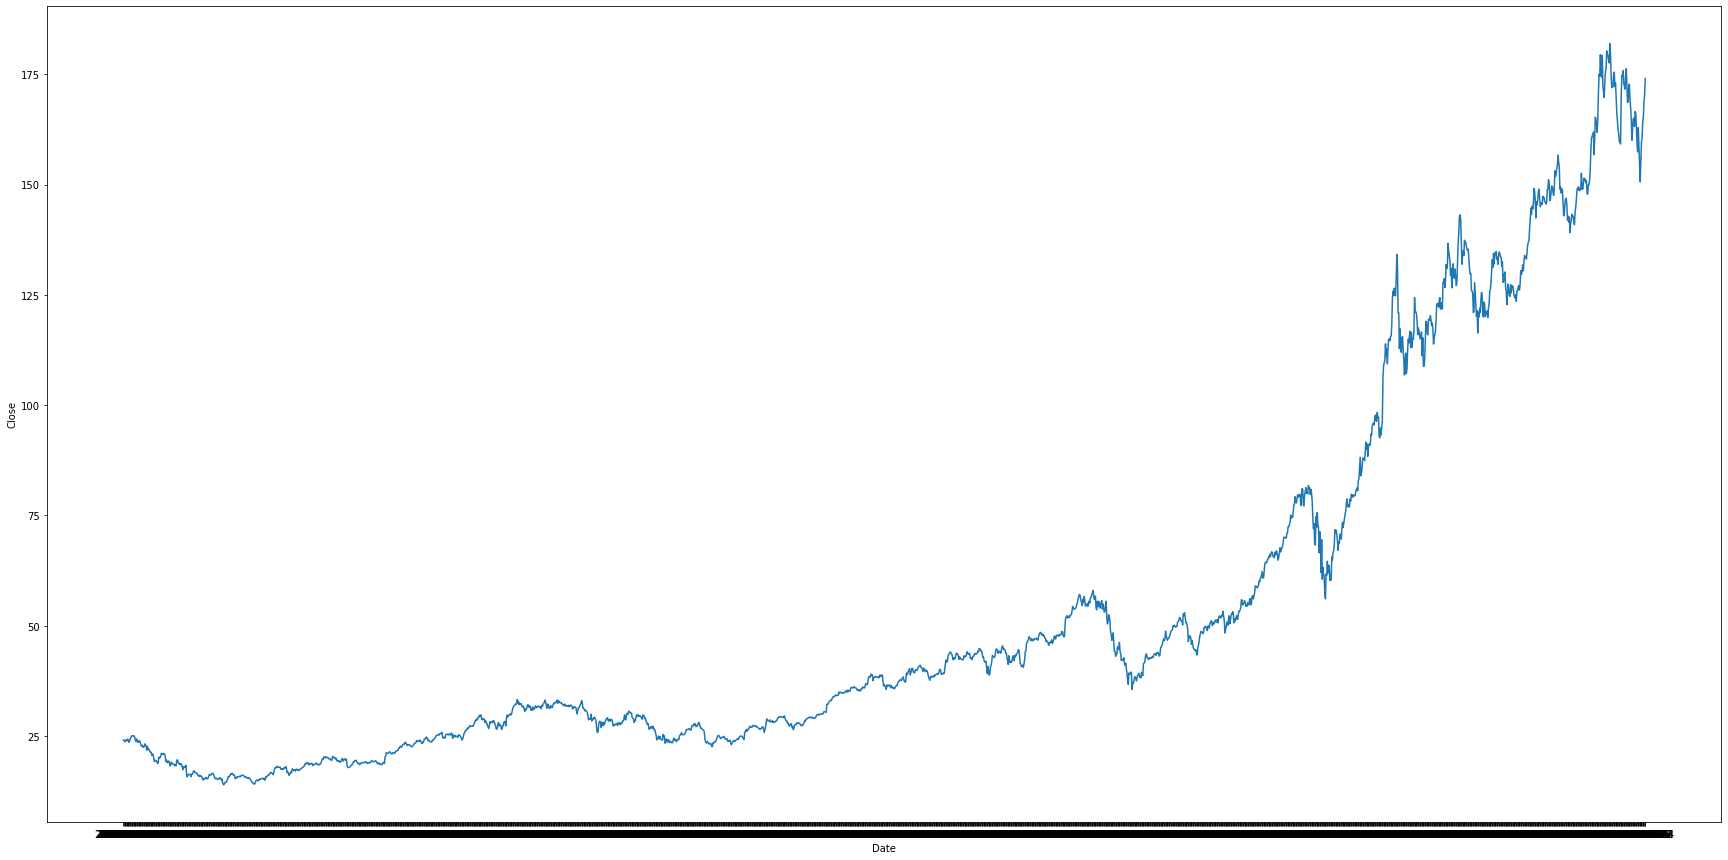

In [214]:
data=df.iloc[8000:].copy()

plt.figure(figsize=(30,15))
ax=sns.lineplot(x=data.index,y=data['Close'])
#plt.xticks(['19/08/2019','16/03/2020','26/02/2021','15/03/2022','05/01/2023'])
plt.show()

In [215]:
data=df.iloc[8000:].copy()

names = cycle(['Stock Open Price','Stock High Price','Stock Low Price','Stock Close Price'])

fig = px.line(data, x=data.index, y=[data['Open'],data['High'], data['Low'],data['Close']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock Analysis', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.show()

In [216]:
ma_day = [30, 60, 120,150]

for ma in ma_day:
        column_name = f"MA for {ma} days"
        data[column_name] = data['Close'].rolling(ma).mean()

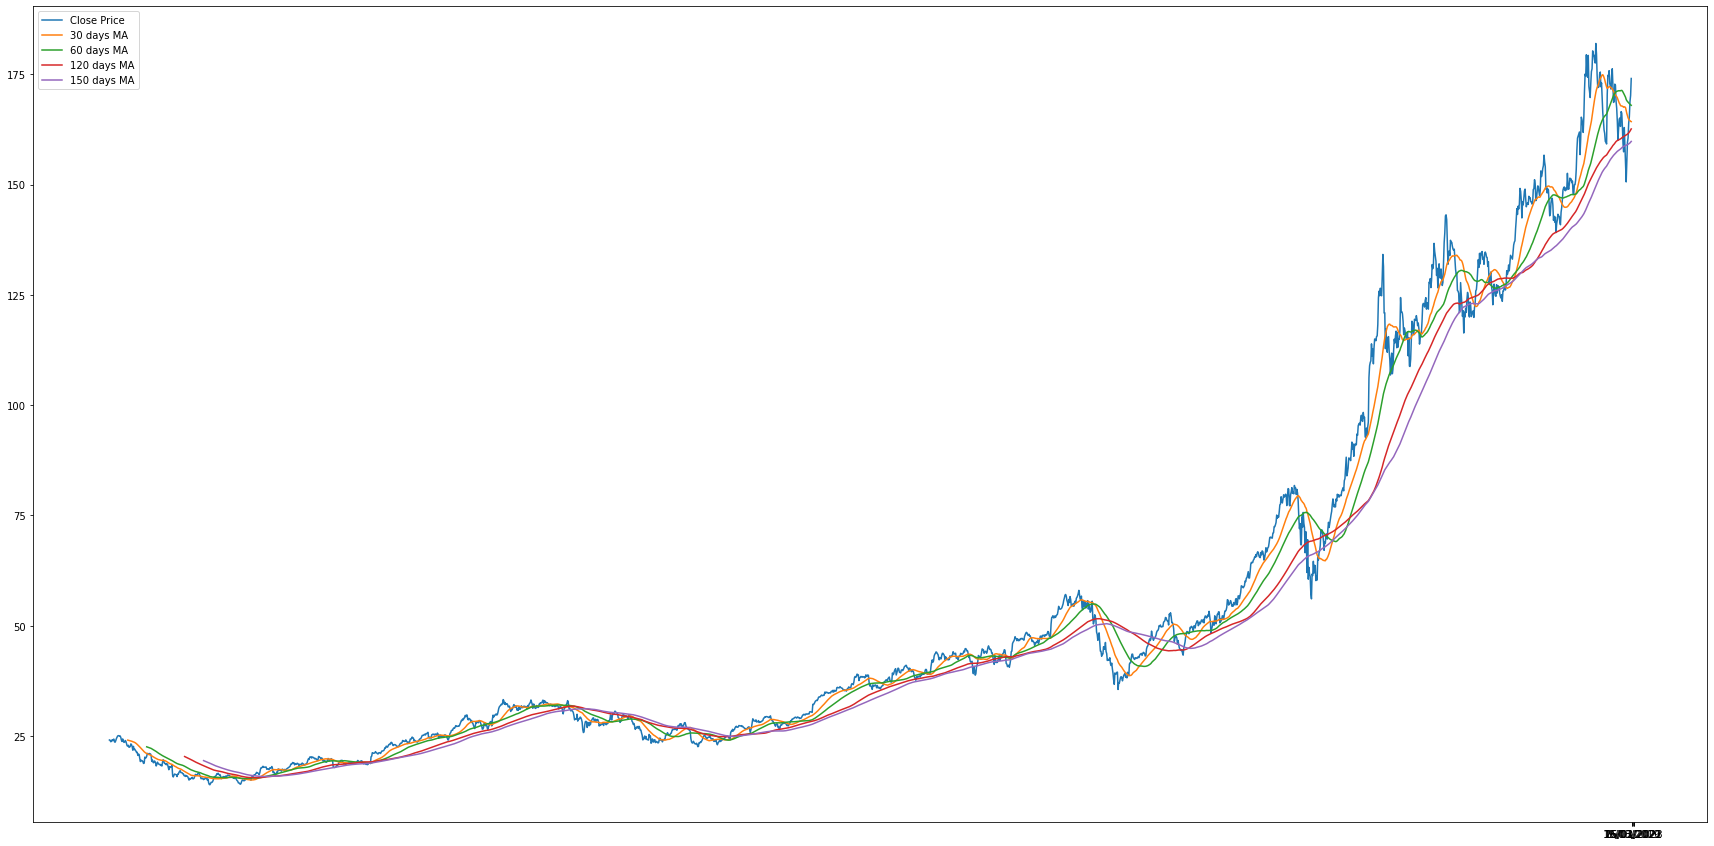

In [217]:
plt.figure(figsize=(30,15))
plt.plot(data['Close'],label='Close Price')
plt.plot(data['MA for 30 days'],label='30 days MA')
plt.plot(data['MA for 60 days'],label='60 days MA')
plt.plot(data['MA for 120 days'],label='120 days MA')
plt.plot(data['MA for 150 days'],label='150 days MA')
plt.xticks(['19/08/2019','16/03/2020','26/02/2021','15/03/2022','05/01/2023'])
plt.legend()
plt.show()

In [218]:
names = cycle(['Close Price','MA 30 days','MA 60 days','MA 120 days','MA 150 days'])

fig = px.line(data, x=data.index ,y=[data['Close'],data['MA for 30 days'],data['MA for 60 days'],data['MA for 120 days'], data['MA for 150 days']],labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Moving Average Analysis', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.show()

In [219]:
# Creating a new dataframe with only 'Close'
new_df = data['Close']
new_df.index = data.index

final_df=new_df.values

train_data=final_df[0:1600,]
test_data=final_df[1600:,]

train_df = pd.DataFrame()
test_df = pd.DataFrame()

train_df['Close'] = train_data
train_df.index = new_df[0:1600].index
test_df['Close'] = test_data
test_df.index = new_df[1600:].index

In [220]:
print("train_data: ", train_df.shape)
print("test_data: ", test_df.shape)

train_data:  (1600, 1)
test_data:  (809, 1)


In [221]:
# Using Min-Max scaler to scale data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_df.reshape(-1,1))

X_train_data,y_train_data=[],[]

for i in range(60,len(train_df)):
    X_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
X_train_data,y_train_data=np.array(X_train_data),np.array(y_train_data)

X_train_data=np.reshape(X_train_data,(X_train_data.shape[0],X_train_data.shape[1],1))

In [222]:
'''
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

'''

'\nmodel = Sequential()\nmodel.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_data.shape[1], 1)))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(units = 50, return_sequences = True))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(units = 50, return_sequences = True))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(units = 50))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(units = 1))\n\n'

In [223]:
# Initializing the LSTM model
'''
from keras.layers import Conv1D, Dropout, Dense, Flatten

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
'''

"\nfrom keras.layers import Conv1D, Dropout, Dense, Flatten\n\nmodel = Sequential()\nmodel.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_data.shape[1], 1)))\nmodel.add(Dropout(0.2))\nmodel.add(Conv1D(filters=64, kernel_size=3, activation='relu'))\nmodel.add(Dropout(0.2))\nmodel.add(Conv1D(filters=64, kernel_size=3, activation='relu'))\nmodel.add(Dropout(0.2))\nmodel.add(Flatten())\nmodel.add(Dense(64, activation='relu'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(1))\n"

In [224]:
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense

model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(X_train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Dense(1))

In [225]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_32 (GRU)                (None, 60, 64)            12864     
                                                                 
 dropout_32 (Dropout)        (None, 60, 64)            0         
                                                                 
 gru_33 (GRU)                (None, 60, 64)            24960     
                                                                 
 dropout_33 (Dropout)        (None, 60, 64)            0         
                                                                 
 gru_34 (GRU)                (None, 60, 64)            24960     
                                                                 
 dropout_34 (Dropout)        (None, 60, 64)            0         
                                                                 
 gru_35 (GRU)                (None, 64)               

In [226]:
'''from keras.optimizers import SGD

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='mean_squared_error')
model.fit(X_train_data, y_train_data, epochs=150, batch_size=32)
'''

"from keras.optimizers import SGD\n\nsgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)\nmodel.compile(optimizer=sgd, loss='mean_squared_error')\nmodel.fit(X_train_data, y_train_data, epochs=150, batch_size=32)\n"

In [227]:
from keras.optimizers import Adam
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
model.compile(optimizer=adam, loss='mean_squared_error')
model.fit(X_train_data, y_train_data, epochs=150, batch_size=32)


Epoch 1/150
49/49 [==============================] - 7s 48ms/step - loss: 0.0013
Epoch 2/150
49/49 [==============================] - 2s 51ms/step - loss: 1.5970e-04
Epoch 3/150
49/49 [==============================] - 2s 48ms/step - loss: 1.6090e-04
Epoch 4/150
49/49 [==============================] - 2s 50ms/step - loss: 1.4890e-04
Epoch 5/150
49/49 [==============================] - 2s 49ms/step - loss: 1.3718e-04
Epoch 6/150
49/49 [==============================] - 2s 49ms/step - loss: 1.4880e-04
Epoch 7/150
49/49 [==============================] - 2s 51ms/step - loss: 1.1744e-04
Epoch 8/150
49/49 [==============================] - 2s 47ms/step - loss: 1.2373e-04
Epoch 9/150
49/49 [==============================] - 2s 49ms/step - loss: 1.1786e-04
Epoch 10/150
49/49 [==============================] - 3s 53ms/step - loss: 1.1492e-04
Epoch 11/150
49/49 [==============================] - 3s 56ms/step - loss: 1.1880e-04
Epoch 12/150
49/49 [==============================] - 3s 53ms/step 

In [228]:
input_data=new_df[len(new_df)-len(test_df)-60:].values
input_data=input_data.reshape(-1,1)
input_data=scaler.transform(input_data)

In [229]:
X_test=[]
for i in range(60,input_data.shape[0]):
    X_test.append(input_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [230]:
predicted=model.predict(X_test)
predicted=scaler.inverse_transform(predicted)

26/26 [==============================] - 1s 15ms/step


In [231]:
test_df['Predictions']=predicted

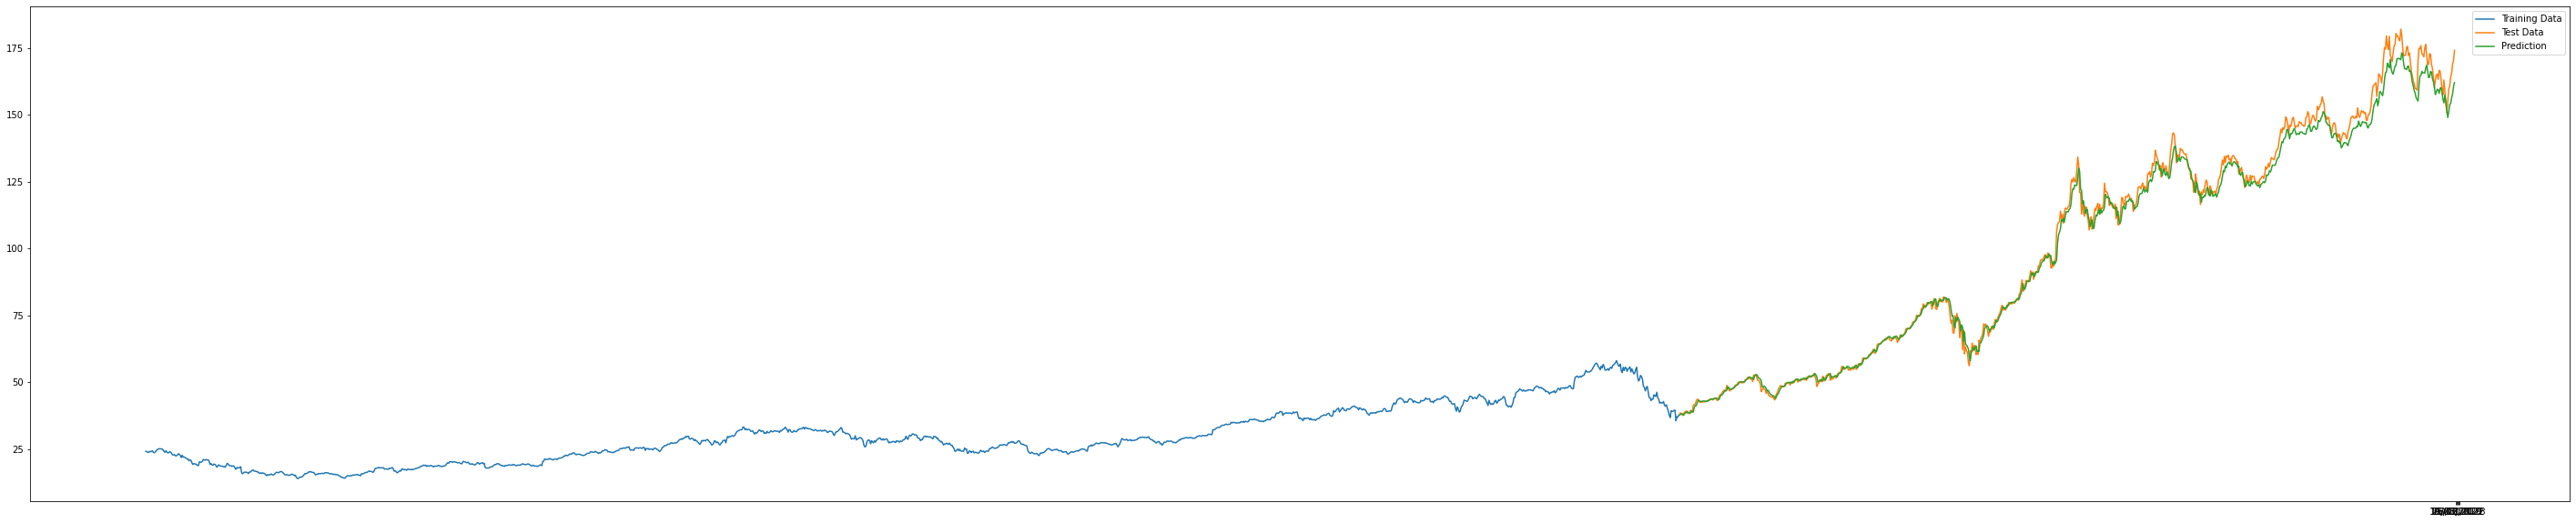

In [232]:
plt.figure(figsize=(50,10))
plt.plot(train_df['Close'],label='Training Data')
plt.plot(test_df['Close'],label='Test Data')
plt.plot(test_df['Predictions'],label='Prediction')
plt.xticks(['19/08/2019','16/03/2020','26/02/2021','15/03/2022','05/01/2023'])
plt.legend()
plt.show()

In [233]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.index,y=train_df['Close'],
                    mode='lines',
                    name='Training Data'))
fig.add_trace(go.Scatter(x=test_df.index,y=test_df['Close'],
                    mode='lines',
                    name='Test Data'))
fig.add_trace(go.Scatter(x=test_df.index,y=test_df['Predictions'],
                    mode='lines',
                    name='Prediction'))

In [234]:
print('The Mean Squared Error is',mean_squared_error(test_df['Close'].values,test_df['Predictions'].values))
print('The Mean Absolute Error is',mean_absolute_error(test_df['Close'].values,test_df['Predictions'].values))
print('The Root Mean Squared Error is',np.sqrt(mean_squared_error(test_df['Close'].values,test_df['Predictions'].values)))

The Mean Squared Error is 11.96618768253641
The Mean Absolute Error is 2.3613795507534863
The Root Mean Squared Error is 3.459217784779734
